In [1]:
from __future__ import unicode_literals
from onmt.utils.logging import init_logger
from onmt.utils.misc import split_corpus
from onmt.translate.translator import build_translator

import onmt.opts as opts
from onmt.utils.parse import ArgumentParser

import matplotlib.pyplot as plt
import numpy as np
import random
import csv

from params_serialize import *
from plotter import *

In [2]:
class plot_agent:
    
    #################################
    ### Model Initialization Part ###
    #################################
    
    def __init__(self, model_addr, src_addr):
        self.translator = self.__build_translator(model_addr, src_addr)
        self.data = None
        self.non_tpspec = "plot_type none contour_plot_type none number_of_levels none density none arrow_size none arrow_style none surface_color none line_style none line_width none line_color none marker_type none marker_size none marker_face_color none marker_edge_width none marker_edge_color none marker_interval none number_of_bins none bar_relative_width none bar_face_color none bar_edge_width none bar_edge_color none bar_orientation none bar_width none bar_height none color_map none explode none precision_digits none percentage_distance_from_center none label_distance_from_center none radius none section_edge_width none section_edge_color none show_error_bar none error_bar_cap_size none error_bar_cap_thickness none error_bar_color none color_bar_orientation none color_bar_length none color_bar_thickness none polarize none x_axis_scale none y_axis_scale none x_axis_position none y_axis_position none data_series_name none font_size none invert_x_axis none invert_y_axis none invert_z_axis none grid_line_type none grid_line_color none grid_line_style none grid_line_width none"
        self.plot_param = deserialize_single_1(self.non_tpspec)
        self.undo_stack = []
        self.redo_stack = []
        self.test_mode = True
        self.src_addr = src_addr
        random.seed(2)
    
    
    def __build_translator(self, model_addr, src_addr):
        parser = ArgumentParser()
        opts.config_opts(parser)
        opts.translate_opts(parser)
        opt = parser.parse_args(['-model', model_addr, '-src', src_addr])
        return build_translator(opt, report_score=False)
    
    
    def __update_tpspec(self, delta_tpspec):
        # The delta_tpspec is in the form of dict()
        ori_param = delta_tpspec.copy() # used to store the params before update
        for k in delta_tpspec.keys():
            ori_param[k] = self.plot_param[k]
            self.plot_param[k] = delta_tpspec[k]
        return ori_param
    
    
    def __natural_lang_translate(self, order):
        text = order
        if "||" not in text:
            text = [serialize_single_1(self.plot_param) + " || " + order]
        out = self.translator.translate(src=text, batch_size=1)
        if self.test_mode:
            print("Delta TPS:", deserialize_single_1(out[1][0][0]))
        return deserialize_single_1(out[1][0][0])
    
    
    #######################
    #### Plotting Part ####
    #######################
    
    
    def generate_data(self):
        self.__formalize_param()
        if self.plot_param['plot_type'] == 'line chart':
            return Line_data_sampler(**self.plot_param)
        elif self.plot_param['plot_type'] == 'histogram':
            return Histogram_data_sampler(**self.plot_param)
        elif self.plot_param['plot_type'] == 'scatter plot':
            return Scatter_data_sampler(**self.plot_param)
        elif self.plot_param['plot_type'] == 'bar plot':
            return Bar_data_sampler(**self.plot_param)
        elif self.plot_param['plot_type'] == 'matrix display':
            return Matrix_display_data_sampler(**self.plot_param)
        elif self.plot_param['plot_type'] == 'contour plot':
            return Contour_data_sampler(**self.plot_param)
        elif self.plot_param['plot_type'] == 'streamline plot':
            return Streamline_data_sampler(**self.plot_param)
        elif self.plot_param['plot_type'] == '3D surface':
            return Surface_3d_data_sampler(**self.plot_param)
        elif self.plot_param['plot_type'] == 'pie chart':
            return Pie_data_sampler(**self.plot_param)
        else:
            return (None, None)
    
    
    def plotting(self):
        if self.data is None:
            return -1
        
        # formalize the plot_param
        self.__formalize_param()
        
        kwargs_unnat = plotter_kwargs_unnaturalize(**self.plot_param)
        try:
            plt.show(plotter(**self.data, **kwargs_unnat))
        except:
            print("information not enough for plotting")
        return 0
    
    
    ## deserilize will turn every boolean, numeric and None-type value into string
    ## which can undermine plotting
    def __formalize_param(self):
        for k in self.plot_param.keys():
            if type(self.plot_param[k]) == str:
                if self.plot_param[k].lower() == 'none':
                    self.plot_param[k] = None
                elif self.plot_param[k].isnumeric() and ('.' in self.plot_param[k]):
                    self.plot_param[k] = float(self.plot_param[k])
                elif self.plot_param[k].isnumeric():
                    self.plot_param[k] = int(self.plot_param[k])
                elif self.plot_param[k].lower() == 'true':
                    self.plot_param[k] = True
                elif self.plot_param[k].lower() == 'false':
                    self.plot_param[k] = False
    
    
    ########################
    #### Interface Part ####
    ########################
    
    def undo(self):
        if len(self.undo_stack) == 0:
            return -1
        delta_param = self.undo_stack.pop()
        ori_param = self.__update_tpspec(delta_param)
        self.redo_stack.append(ori_param)
        return 0
        
    
    def redo(self):
        if len(self.redo_stack) == 0:
            return -1
        delta_param = self.redo_stack.pop()
        ori_param = self.__update_tpspec(delta_param)
        self.undo_stack.append(ori_param)
        return 0
    
    
    def update(self, delta_tpspec):
        ori_param = self.__update_tpspec(delta_tpspec)
        
        self.undo_stack.append(ori_param)
        # manual input, clear redo stack
        self.redo_stack = []
        
    
    def __param_print(self):
        tmp = []
        for k in self.plot_param.keys():
            if self.plot_param[k] != None and self.plot_param[k] != "none":
                tmp.append((k, self.plot_param[k]))
        print(tmp)
    

    # load a dialog from a file
    def load_dialog(self, file_addr):
        with open(file_addr) as f:
            for ins in f:
                ins = ins.replace('\n', '')
                if self.test_mode:
                    print("Input instruction:", ins)
                self.update(self.__natural_lang_translate(ins))
    
    
    # load a dialog from a training/test file:
    def load_dialog_format(self, file_addr):
        with open(file_addr) as f:
            all_ins = f.read().split(self.non_tpspec)
            ins_set = random.choice(all_ins).split('\n')
            for ins in ins_set[:len(ins_set)-1]:
                ins = ins.split('|| ')[1]
                if self.test_mode:
                    print("Input instruction:", ins)
                self.update(self.__natural_lang_translate(ins))
    
    
    def interface(self):
        while True:
            ins = input("Enter your instruction: ")
            if ins=="undo":
                if self.undo() == -1:
                    print("undo failed.")
                if self.test_mode:
                    self.plotting()
            
            elif ins=="redo":
                if self.redo() == -1:
                    print("redo failed.")
                if self.test_mode:
                    self.plotting()
                    
            elif ins=="plot":
                if self.plotting() == -1:
                    print("Plot failed, data missing.")
                    inq = input("Do you want to generate data? (Y/n): ")
                    if inq == 'Y' or inq == 'y':
                        self.data, label_setting = self.generate_data()
                        if self.data == None:
                            print("Please specify the plot type.")
                        else:
                            self.update(label_setting)
                            self.plotting()
            
            elif ins=="generate data":
                self.data, label_setting = self.generate_data()
                if self.data == None:
                    print("Data generation failed. Please specify the plot type.")
                else:
                    self.update(label_setting)
            
            elif ins=="print param":
                self.__param_print()
            
            elif ins=="load data":
                data_type=input("Enter the type of your data: ")
                data_addr=input("Enter the address of your data file: ")
                data_got = self.__data_reader(data_type, data_addr)
                if data_got is None:
                    print("Data loading failed")
                else:
                    self.data = data_got
                    
            elif ins=="load csv":
                self.data=self.csv_interface()
                    
            elif ins=="load dialog":
                file_addr=input("What's the path of the dialog file? ")
                try:
                    self.load_dialog(file_addr)
                except FileNotFoundError:
                    print("It seems I can't find your dialog file with the given path.")
                    
            elif ins=="load source dialog":
                self.load_dialog_format(self.src_addr)
            
            elif ins=='end':
                break;
            
            elif ins=='test':
                self.test_mode = !self.test_mode
            
            elif ins=='reset':
                self.data = None
                self.plot_param = deserialize_single_1(self.non_tpspec)
                self.undo_stack = []
                self.redo_stack = []
            
            else:
                self.update(self.__natural_lang_translate(ins))
                if self.test_mode: 
                    self.plotting()
    
    
    def __data_reader(self, data_type, src_addr):
        with open(src_addr) as f:
            dat = f.read().split('\n')

            # data_req = 1d xy
            if data_type == "pie":
                x = tuple(dat[0].split(" "))
                y = [float(d) for d in dat[1].split(" ")]
                return {'x':x, 'y':y, 'c_type':data_type}

            # data_req = 1d xyz
            elif data_type == 'line' or data_type == 'scatter':
                x = np.array([float(d) for d in dat[0].split(" ")])
                y = np.array([float(d) for d in dat[1].split(" ")])
                z = np.array([float(d) for d in dat[2].split(" ")])
                return {'x':x, 'y':y, 'z':z, 'c_type':data_type}

            # data_req = 1d xyz + bar_base (single float)
            elif data_type == 'bar':
                x = np.array([float(d) for d in dat[0].split(" ")])
                y = np.array([float(d) for d in dat[1].split(" ")])
                z = np.array([float(d) for d in dat[2].split(" ")])
                bar_base = float(dat[3])
                return {'x':x, 'y':y, 'z':z, 'bar_base':bar_base, 'c_type':data_type}

            # data_req = 1d x + hist_range (two integer indicating range)
            elif data_type == 'histogram':
                x = np.array([float(d) for d in dat[0].split(" ")])
                his = dat[1].replace(",", "").replace("(", "").replace(")", "").split(" ")
                hist_range = (int(his[0]), int(his[1]))
                return {'x':x, 'hist_range':hist_range, 'c_type':data_type}

            # data_req = 2d x
            elif data_type == 'matrix_display':
                x = []
                for line in dat:
                    x.append([float(d) for d in line.split(" ")])
                return {'x':np.array(x), 'c_type':data_type}

            # data_req = 2d xyz
            elif data_type == 'contour' or data_type == 'surface_3d':
                dimen = [[], [], []]
                cur_dim = 0
                for line in dat:
                    # there are only 3 dimension for this data. Each dimension is divided by a blank line.
                    if cur_dim >= 3:
                        return None
                    if line == "":
                        cur_dim += 1
                    else:
                        dimen[cur_dim].append([float(d) for d in line.split(" ")])
                return {'x':np.array(dimen[0]), 'y':np.array(dimen[1]), 'z':np.array(dimen[2]), 'c_type':data_type}

            # data_req = 2d xyuvz
            elif data_type == 'streamline':
                dimen = [[], [], [], [], []]
                cur_dim = 0
                for line in dat:
                    # there are only 5 dimension for this data. Each dimension is divided by a blank line.
                    if cur_dim >= 5:
                        return None
                    if line == "":
                        cur_dim += 1
                    else:
                        dimen[cur_dim].append([float(d) for d in line.split(" ")])
                return {'x':np.array(dimen[0]), 'y':np.array(dimen[1]), 'u':np.array(dimen[2]),
                        'y':np.array(dimen[3]), 'z':np.array(dimen[4]), 'c_type':data_type}

            # data type not identified
            else:
                return None
     
    
    def __query_help(self, hint, header, data):
        q = input(hint)
        while q[0] == '?':
            q = q.replace('?', '')
            if ':' not in q:
                if q == "header":
                    print(header)
                elif q in header:
                    print(header.index(q), set([data[d][q] for d in range(0, len(data))]))
                else:
                    print("Cannot process the query. Please try again.")
            else:
                q = q.split(':')
                if q[1] not in header:
                    print("The attribute is not in header. Please try again.")
                else:
                    l = [data[d][q[1]] for d in range(0, len(data))]
                    if q[0] not in l:
                        print("The element is not in the specified attribute. Please try again.")
                    else:
                        print(l.index(q[0]))
            q = input(hint)
        return q
        
    
    def __query_data(self, hint, header, data):
        ins = self.__query_help(hint, header, data)
        if '|' not in ins:
            print("Format is not correct. Please try again.")
            return query_data(hint, header, data)
        r, c = ins.split('|')
        if '-' not in c:
            if c == 'all':
                c = [i for i in range(0, len(header))]
            else:
                c = [int(c)]
        else:
            c = c.split('-')
            c = [d for d in range(int(c[0]), int(c[1])+1)]

        if '-' not in r:
            if r == 'all':
                r = [i for i in range(0, len(data))]
            elif r == 'header':
                dt = []
                for j in c:
                    dt.append(header[j])
                return dt
            else:
                r = [int(r)]
        else:
            r = r.split('-')
            r = [d for d in range(int(r[0]), int(r[1])+1)]   

        dt = []
        for i in r:
            row = []
            for j in c:
                row.append(data[i][header[j]])
            dt.append(row)
        dt = np.array(dt)
        if dt.shape[1] == 1:
            if dt.shape[0] == 1:
                return dt[0][0]
            else:
                return dt.T[0]
        elif dt.shape[0] == 1:
            return dt[0]
        else:
            return dt
    
    
    def csv_interface(self):
        csv_addr = input("Please tell me the path of your csv file: ")
        stats = []
        with open(csv_addr) as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                for r in row.keys():
                    if row[r].isnumeric() and '.' in row[r]:
                        row[r] = float(row[r])
                    elif row[r].isnumeric():
                        row[r] = int(row[r])
                stats.append(row)


        header = list(stats[0].keys())
        print("Data loading done.")
        data = dict()
        while True:
            label = input("Please specify the label of the data you want to cover [x/y/z/u/v/hist_range/bar_base]: ")
            if label == 'hist_range':
                ran = input("Please specify the histogram range [x, y]: ")
                dat = (int(ran[0]), int(ran[1]))
            elif label == 'bar_base':
                base = input("Please specify the bar base [a number]: ")
                dat = float(base)
            else:
                dat = self.__query_data("Please specify data range [r|c] (229|4-105 denotes row 229 column 4-105)", header, stats)
            data.update({label:dat})
            con = input("Do you want to continue specify data? [y/n]: ")
            if con == 'n':
                break
        c_type = input("Please specify your intended chart type [bar/line/pie/streamline/contour/histogram/scatter/surface_3d/matrix_display]")
        data.update({'c_type':c_type})
        if c_type == 'pie':
            data['x'] = tuple(data['x'])
        print("Data generated from the csv file!")
        return data

In [3]:
model_address = '../../ChartDialog-save/save_models/s2s_single.1/model.s2s_single.1_step_100000.pt'
src_address = '../../ChartDialog-save/s2s_single/src.test.txt'

In [4]:
agt = plot_agent(model_address, src_address)

Enter your instruction: load source dialog
Input instruction: it 's a pie chart with a small explosion . percentage labels are close .


/home/yihan/py-pjt/chartdialogs/.venv/lib/python3.6/site-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


Delta TPS: OrderedDict([('plot_type', 'pie chart'), ('explode', 'small'), ('precision_digits', '0'), ('percentage_distance_from_center', 'near'), ('label_distance_from_center', 'near'), ('radius', 'medium'), ('font_size', 'medium')])
Input instruction: data labels farther out and decrease radius
Delta TPS: OrderedDict([('label_distance_from_center', 'far'), ('radius', 'small')])
Enter your instruction: generate data
Enter your instruction: plot


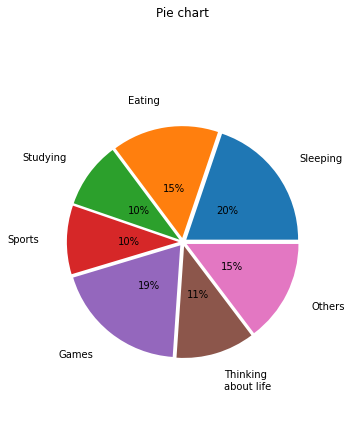

Enter your instruction: reset
Enter your instruction: load source dialog
Input instruction: hi , this is a 3d chart with a solid blue shape . no inverted axes .
Delta TPS: OrderedDict([('plot_type', '3D surface'), ('surface_color', 'blue'), ('font_size', 'medium'), ('invert_x_axis', 'True'), ('invert_y_axis', 'False'), ('invert_z_axis', 'False')])
Enter your instruction: generate data
Enter your instruction: plot


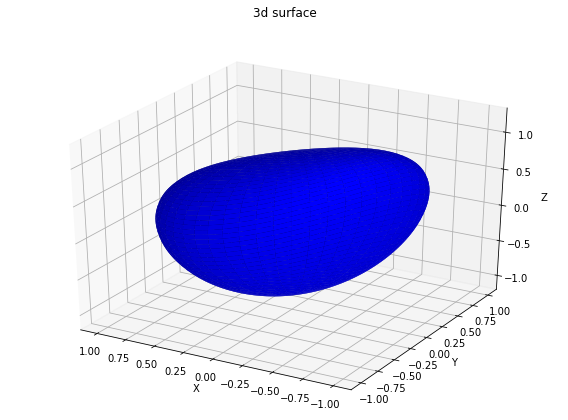

Enter your instruction: reset
Enter your instruction: load source dialog
Input instruction: it 's a contour plot . the color map is magenta to yellow . the color bar is horizontal , thick , with 15 levels
Delta TPS: OrderedDict([('plot_type', 'contour plot'), ('contour_plot_type', 'filled'), ('number_of_levels', '15'), ('color_map', 'magenta to yellow'), ('color_bar_orientation', 'horizontal'), ('color_bar_length', 'short'), ('color_bar_thickness', 'thick'), ('polarize', 'False'), ('x_axis_scale', 'linear'), ('y_axis_scale', 'linear'), ('x_axis_position', 'bottom'), ('y_axis_position', 'left'), ('font_size', 'medium'), ('invert_x_axis', 'False'), ('invert_y_axis', 'False')])
Input instruction: it 's lined rather than filled . the color bar is long . both x and y axes are log . the font size is large
Delta TPS: OrderedDict([('contour_plot_type', 'lined'), ('line_style', 'solid'), ('line_width', 'medium'), ('color_bar_length', 'long'), ('x_axis_scale', 'log'), ('y_axis_scale', 'log'), ('

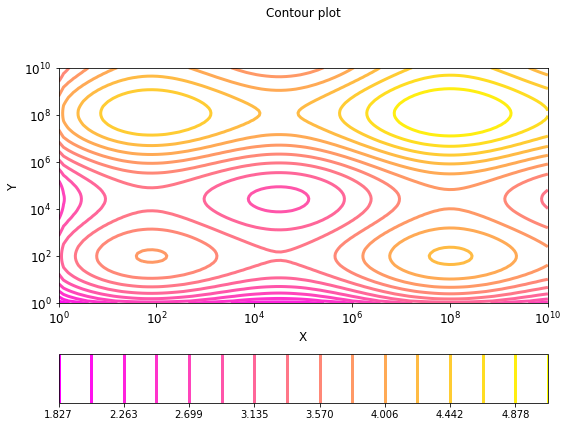

Enter your instruction: reset
Enter your instruction: load dialog
What's the path of the dialog file? ./dialog_test
Input instruction: line graph ; solid orange ; round magenta markers ; polarized ; name trajectory
Delta TPS: OrderedDict([('plot_type', 'line chart'), ('line_style', 'solid'), ('line_width', 'medium'), ('line_color', 'orange'), ('marker_type', 'circles'), ('marker_size', 'small'), ('marker_face_color', 'magenta'), ('marker_interval', '1'), ('polarize', 'True'), ('data_series_name', 'Trajectory'), ('font_size', 'medium')])
Input instruction: grid lines both vert and horiz , gray dash/dots ; large markers
Delta TPS: OrderedDict([('marker_size', 'large'), ('grid_line_type', 'both'), ('grid_line_color', 'gray'), ('grid_line_style', 'dashed dots'), ('grid_line_width', 'very thin')])
Input instruction: marker interval 3
Delta TPS: OrderedDict([('marker_interval', '2')])
Input instruction: larger interval
Delta TPS: OrderedDict([('marker_interval', '5')])
Input instruction: gri

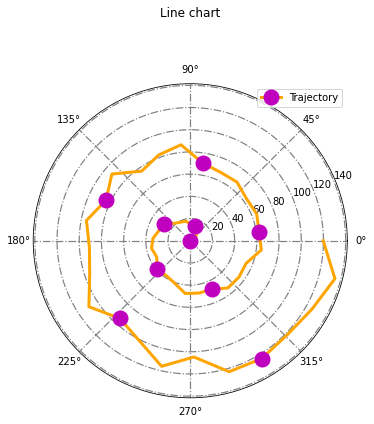

Enter your instruction: larger font


/home/yihan/py-pjt/chartdialogs/.venv/lib/python3.6/site-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


Delta TPS: OrderedDict([('font_size', 'large')])


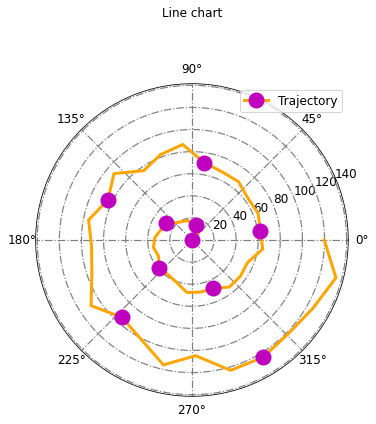

Enter your instruction: line color red


/home/yihan/py-pjt/chartdialogs/.venv/lib/python3.6/site-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


Delta TPS: OrderedDict([('line_color', 'red')])


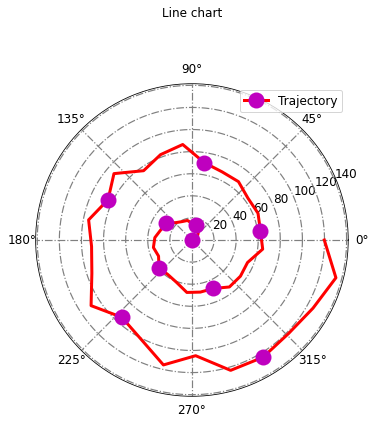

Enter your instruction: reset
Enter your instruction: load csv
Please tell me the path of your csv file: covid_confirmed_usafacts.csv
Data loading done.
Please specify the label of the data you want to cover [x/y/z/u/v/hist_range/bar_base]: x
Please specify data range [r|c] (229|4-105 denotes row 229 column 4-105)header|4-105
Do you want to continue specify data? [y/n]: y
Please specify the label of the data you want to cover [x/y/z/u/v/hist_range/bar_base]: y
Please specify data range [r|c] (229|4-105 denotes row 229 column 4-105)229|4-105
Do you want to continue specify data? [y/n]: n
Please specify your intended chart type [bar/line/pie/streamline/contour/histogram/scatter/surface_3d/matrix_display]line
Data generated from the csv file!
Enter your instruction: line chart


/home/yihan/py-pjt/chartdialogs/.venv/lib/python3.6/site-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


Delta TPS: OrderedDict([('plot_type', 'line chart'), ('line_style', 'solid'), ('line_width', 'medium'), ('line_color', 'black'), ('show_error_bar', 'False'), ('polarize', 'False'), ('x_axis_scale', 'linear'), ('y_axis_scale', 'linear'), ('x_axis_position', 'bottom'), ('y_axis_position', 'left'), ('font_size', 'medium'), ('invert_x_axis', 'False'), ('invert_y_axis', 'False')])


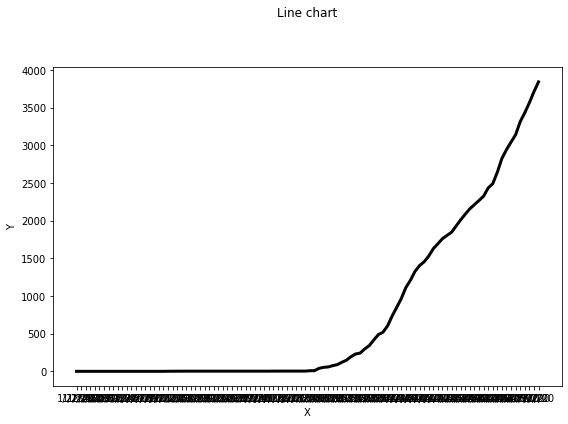

Enter your instruction: load csv
Please tell me the path of your csv file: covid_confirmed_usafacts.csv
Data loading done.
Please specify the label of the data you want to cover [x/y/z/u/v/hist_range/bar_base]: x
Please specify data range [r|c] (229|4-105 denotes row 229 column 4-105)?header
['\ufeffcountyFIPS', 'County Name', 'State', 'stateFIPS', '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20', '3/21/20', '3/22/2

NameError: name 'query_data' is not defined

In [5]:
agt.interface()

In [75]:
plots = ['bar','line','pie','streamline','contour','histogram','scatter','surface_3d','matrix_display']
plot_types = ['bar plot', 'line chart', 'pie chart','streamline plot', 'contour plot','histogram', 'scatter plot','3D surface', 'matrix display']
requirements = ['1xyz+bar_base', '1xyz', '1xy', '2xyuvz', '2xyz', '1x+hist_range', '1xyz', '2xyz', '2x']

In [128]:
for p in plot_types:
    data,_ = sample_one(p)
    print(p, data)

bar plot {'x': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), 'y': array([7.63922644e+01, 3.62132637e+01, 4.65896993e+02, 1.79937857e+02,
       5.03266845e+02, 7.09836370e+03, 4.55263297e+04, 1.10896630e+04,
       4.65569204e+05, 5.82822410e+04, 1.00000000e+06]), 'z': array([3.99998888e+01, 2.57527272e+01, 3.44821925e+02, 1.11550516e+02,
       2.68049476e+02, 4.73012233e+03, 2.43814155e+04, 5.79814802e+03,
       2.37651462e+05, 3.63768116e+04, 6.94207002e+05]), 'bar_base': 6.196599093739533, 'c_type': 'bar'}
line chart {'x': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), 'y': array([153.99143431, 214.0351422 , 177.19107798, 139.32400358,
       179.37913866, 174.56691873, 142.60480636, 187.50369274,
       150.9159541 , 166.09821967, 192.02372668]), 'z': array([3.82729692, 2.27279933, 2.15769851, 3.60883325, 2.19189453,
       3.14644471, 3.89508178, 3.00550805, 2.23942145, 2.45288903,
       2.05787463]), 'c_type': 'line'}
pie chart {'x': ('Sleepi

In [106]:
for p in plot_types:
    data,_ = sample_one(p)
    print(p)
    print(data.keys())

bar plot
dict_keys(['x', 'y', 'z', 'bar_base', 'c_type'])
line chart
dict_keys(['x', 'y', 'z', 'c_type'])
pie chart
dict_keys(['x', 'y', 'c_type'])
streamline plot
dict_keys(['x', 'y', 'u', 'v', 'z', 'c_type'])
contour plot
dict_keys(['x', 'y', 'z', 'c_type'])
histogram
dict_keys(['x', 'hist_range', 'c_type'])
scatter plot
dict_keys(['x', 'y', 'z', 'c_type'])
3D surface
dict_keys(['x', 'y', 'z', 'c_type'])
matrix display
dict_keys(['x', 'c_type'])


In [151]:
def data_reader(data_type, src_addr):
    with open(src_addr) as f:
        dat = f.read().split('\n')
        
        # data_req = 1d xy
        if data_type == "pie":
            x = tuple(dat[0].split(" "))
            y = [float(d) for d in dat[1].split(" ")]
            return {'x':x, 'y':y, 'c_type':data_type}
        
        # data_req = 1d xyz
        elif data_type == 'line' or data_type == 'scatter':
            x = np.array([float(d) for d in dat[0].split(" ")])
            y = np.array([float(d) for d in dat[1].split(" ")])
            z = np.array([float(d) for d in dat[2].split(" ")])
            return {'x':x, 'y':y, 'z':z, 'c_type':data_type}
        
        # data_req = 1d xyz + bar_base (single float)
        elif data_type == 'bar':
            x = np.array([float(d) for d in dat[0].split(" ")])
            y = np.array([float(d) for d in dat[1].split(" ")])
            z = np.array([float(d) for d in dat[2].split(" ")])
            bar_base = float(dat[3])
            return {'x':x, 'y':y, 'z':z, 'bar_base':bar_base, 'c_type':data_type}
        
        # data_req = 1d x + hist_range (two integer indicating range)
        elif data_type == 'histogram':
            x = np.array([float(d) for d in dat[0].split(" ")])
            his = dat[1].replace(",", "").replace("(", "").replace(")", "").split(" ")
            hist_range = (int(his[0]), int(his[1]))
            return {'x':x, 'hist_range':hist_range, 'c_type':data_type}
        
        # data_req = 2d x
        elif data_type == 'matrix_display':
            x = []
            for line in dat:
                x.append([float(d) for d in line.split(" ")])
            return {'x':np.array(x), 'c_type':data_type}
        
        # data_req = 2d xyz
        elif data_type == 'contour' or data_type == 'surface_3d':
            dimen = [[], [], []]
            cur_dim = 0
            for line in dat:
                # there are only 3 dimension for this data. Each dimension is divided by a blank line.
                if cur_dim >= 3:
                    return None
                if line == "":
                    cur_dim += 1
                else:
                    dimen[cur_dim].append([float(d) for d in line.split(" ")])
            return {'x':np.array(dimen[0]), 'y':np.array(dimen[1]), 'z':np.array(dimen[2]), 'c_type':data_type}
        
        # data_req = 2d xyuvz
        elif data_type == 'streamline':
            dimen = [[], [], [], [], []]
            cur_dim = 0
            for line in dat:
                # there are only 5 dimension for this data. Each dimension is divided by a blank line.
                if cur_dim >= 5:
                    return None
                if line == "":
                    cur_dim += 1
                else:
                    dimen[cur_dim].append([float(d) for d in line.split(" ")])
            return {'x':np.array(dimen[0]), 'y':np.array(dimen[1]), 'u':np.array(dimen[2]),
                    'y':np.array(dimen[3]), 'z':np.array(dimen[4]), 'c_type':data_type}
        
        # data type not identified
        else:
            return None

In [150]:
data_reader("pie", "user_pie.txt")

{'x': ('sleeping', 'studying', 'distracting'),
 'y': [0.3, 0.35, 0.35],
 'c_type': 'pie'}

In [33]:
def query_help(hint, header, data):
    q = input(hint)
    while q[0] == '?':
        q = q.replace('?', '')
        if ':' not in q:
            if q == "header":
                print(header)
            elif q in header:
                print(header.index(q), set([data[d][q] for d in range(0, len(data))]))
            else:
                print("Cannot process the query. Please try again.")
        else:
            q = q.split(':')
            if q[1] not in header:
                print("The attribute is not in header. Please try again.")
            else:
                l = [data[d][q[1]] for d in range(0, len(data))]
                if q[0] not in l:
                    print("The element is not in the specified attribute. Please try again.")
                else:
                    print(l.index(q[0]))
        q = input(hint)
    return q

In [42]:
def query_data(hint, header, data):
    ins = query_help(hint, header, data)
    if '|' not in ins:
        print("Format is not correct. Please try again.")
        return query_data(hint, header, data)
    r, c = ins.split('|')
    if '-' not in c:
        if c == 'all':
            c = [i for i in range(0, len(header))]
        else:
            c = [int(c)]
    else:
        c = c.split('-')
        c = [d for d in range(int(c[0]), int(c[1])+1)]

    if '-' not in r:
        if r == 'all':
            r = [i for i in range(0, len(data))]
        elif r == 'header':
            dt = []
            for j in c:
                dt.append(header[j])
            return dt
        else:
            r = [int(r)]
    else:
        r = r.split('-')
        r = [d for d in range(int(r[0]), int(r[1])+1)]   
    
    dt = []
    for i in r:
        row = []
        for j in c:
            row.append(data[i][header[j]])
        dt.append(row)
    dt = np.array(dt)
    if dt.shape[1] == 1:
        if dt.shape[0] == 1:
            return dt[0][0]
        else:
            return dt.T[0]
    elif dt.shape[0] == 1:
        return dt[0]
    else:
        return dt

In [49]:
def csv_interface():
    csv_addr = input("Please tell me the path of your csv file: ")
    stats = []
    with open(csv_addr) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            for r in row.keys():
                if row[r].isnumeric() and '.' in row[r]:
                    row[r] = float(row[r])
                elif row[r].isnumeric():
                    row[r] = int(row[r])
            stats.append(row)
    
    
    header = list(stats[0].keys())
    print("Data loading done.")
    data = dict()
    while True:
        label = input("Please specify the label of the data you want to cover [x/y/z/u/v/hist_range/bar_base]: ")
        if label == 'hist_range':
            ran = input("Please specify the histogram range [x, y]: ")
            dat = (int(ran[0]), int(ran[1]))
        elif label == 'bar_base':
            base = input("Please specify the bar base [a number]: ")
            dat = float(base)
        else:
            dat = query_data("Please specify data range [r|c] (229|4-105 denotes row 229 column 4-105)", header, stats)
        data.update({label:dat})
        con = input("Do you want to continue specify data? [y/n]: ")
        if con == 'n':
            break
    c_type = input("Please specify your intended chart type [bar/line/pie/streamline/contour/histogram/scatter/surface_3d/matrix_display]")
    data.update({'c_type':c_type})
    if c_type == 'pie':
        data['x'] = tuple(data['x'])
    print("Data generated from the csv file!")
    return data

In [50]:
ta = csv_interface()

Please tell me the path of your csv file: covid_confirmed_usafacts.csv
Data loading done.
Please specify the label of the data you want to cover(x/y/z/u/v/hist_range/bar_base): x
Please specify data range [r|c] (229|4-105 denotes row 229 column 4-105)header|4-105
Do you want to continue specify data? [y/n]: y
Please specify the label of the data you want to cover(x/y/z/u/v/hist_range/bar_base): y
Please specify data range [r|c] (229|4-105 denotes row 229 column 4-105)229|4-105
Do you want to continue specify data? [y/n]: n
Please specify your intended chart type (bar/line/pie/streamline/contour/histogram/scatter/surface_3d/matrix_display)pie
Data generated from the csv file!
